In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Solution to the Assignment 1 of FHPC

## Part 1: theoretical model

### Naive algerithm: best $P$

First I would like to notice the various terms of $T(P,N)$:
 - $T_{\text{read}}$: time to read the numbers;
 - $(P-1)T_{\text{comm.}}$: time to communicate to $P-1$ slaves;
 - $\left(\left\lceil\frac{N}{P}\right\rceil -1\right)T_{\text{comp.}}$: time for each core (in the worst case) to compute the sum;
 - $(P-1)T_{\text{comm.}}$: time to collect the result;
 - $(P-1)T_{\text{comp.}}$: time to sum up all the partial result.
 All in all we have:
 $$
 T(P,N) = T_{\text{read}} + 2(P-1)T_{\text{comm.}} + \left(\left\lceil\frac{N}{P}\right\rceil+P-2\right)T_{\text{comp.}}\;.
 $$
 We notice a little discrepancy with formula given in the assignment. In the following we will use:
    | Time                  | Value ($\mathrm{s}$) |
    |-----------------------|---------------------:|
    | $T_{\text{read}}$     | $10^{-4}$            |
    | $T_{\text{comm.}}$    | $10^{-6}$            |
    | $T_{\text{comp.}}$    | $2\cdot 10^{-9}$     |

In [2]:
# Here we generate times for various N and P

t_read = 1e-4
t_comm = 1e-6
t_comp = 2e-9

def time(p, n):
    return t_read + 2*(p-1)*t_comm + (np.ceil(n/p)+p-2)*t_comp

p_points = np.arange(1, 1e4+1, dtype=int)
n_points = np.array([2e4, 1e5, 2e5, 1e7, 2e8], dtype=int)

times = time(*np.meshgrid(p_points, n_points)).T

In [3]:
# Here the data are shown (just a few bit)

data = pd.DataFrame(index=p_points, data=times, columns=n_points)
data.columns.name = "N"
data.index.name = "P"

data.head().style.format("{:.2e}")

N,20000,100000,200000,10000000,200000000
P,,,,,
1,1.40e-04,3.00e-04,5.00e-04,2.01e-02,4.00e-01
2,1.22e-04,2.02e-04,3.02e-04,1.01e-02,2.00e-01
3,1.17e-04,1.71e-04,2.37e-04,6.77e-03,1.33e-01
4,1.16e-04,1.56e-04,2.06e-04,5.11e-03,1.00e-01
5,1.16e-04,1.48e-04,1.88e-04,4.11e-03,8.01e-02


We can seek for the minimum numerically or analitically: for a given $N$ the function $T(P,N)$ is minimized for $P\sim \sqrt{N}\cdot\sqrt{\frac{T_{\text{comp.}}}{2T_{\text{comm.}}+T_{\text{comp.}}}}$.

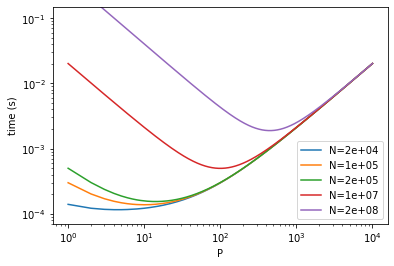

In [4]:
# Here we plot some value in a log-log scale

n_legend = ["N={:.0e}".format(n) for n in n_points ] 
fig, ax = plt.subplots()
ax.loglog(p_points, times)
ax.set_ylim(7e-5, 15e-2)
ax.set_xlabel("P")
ax.set_ylabel("time (s)")
ax.legend(n_legend)

plt.show()

In [5]:
# We show that numeric minimization actually coicides with analytical one

res = data.apply(['idxmin', 'min']).transpose()
res.index.name = "N"
res = res.rename(columns={"idxmin": "Pmin"})
idxmin_a = pd.Series(res.index, index=res.index).apply(lambda x: np.round(np.sqrt(x)*np.sqrt(t_comp/(2*t_comm ))))
res.insert(1, "Pmin_a", idxmin_a)
res = res.astype({"Pmin": int, "Pmin_a": int, "min": float})

res.style.format({"min": "{:.2e}"})

,Pmin,Pmin_a,min
N,,,
20000,4,4,1.16e-04
100000,10,10,1.38e-04
200000,14,14,1.55e-04
10000000,100,100,4.98e-04
200000000,447,447,1.89e-03


### Improvement of the algorithm

Perhaps it is possible to save some communication time. The idea are basically two:
 - One can share a variable with the slave process. Every process does know in which location of the variable it can write. So the end communication can be done all at once in a time $T_{\text{comm.}}$;
 - Even at the beginning, after the master have read all the numbers perhaps it can communicate those number to each slave (almost) simultaneously.
 
 All in all the new time is
 $$
 \tilde{T}(P,N) = T_{\text{read}} + 2T_{\text{comm.}} + \left(\left\lceil\frac{N}{P}\right\rceil+P-2\right)T_{\text{comp.}}\;.
 $$

In [6]:
# With the new time

def time_improved(p, n):
    return t_read + 2*t_comm + (np.ceil(n/p)+p-2)*t_comp

p_points_improved = np.arange(1, 1e5+1, dtype=int)

times_improved = time_improved(*np.meshgrid(p_points_improved, n_points)).T

In [7]:
# Here the data are shown (just a few bit)

data_improved = pd.DataFrame(index=p_points_improved, data=times_improved, columns=n_points)
data_improved.columns.name = "N"
data_improved.index.name = "P"

data_improved.head().style.format("{:.2e}")

N,20000,100000,200000,10000000,200000000
P,,,,,
1,1.42e-04,3.02e-04,5.02e-04,2.01e-02,4.00e-01
2,1.22e-04,2.02e-04,3.02e-04,1.01e-02,2.00e-01
3,1.15e-04,1.69e-04,2.35e-04,6.77e-03,1.33e-01
4,1.12e-04,1.52e-04,2.02e-04,5.10e-03,1.00e-01
5,1.10e-04,1.42e-04,1.82e-04,4.10e-03,8.01e-02


We can seek for the minimum numerically or analitically: for a given $N$ the function $T(P,N)$ is minimized for $P\sim\sqrt{N}$.

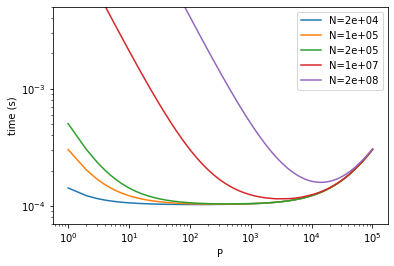

In [8]:
# Here we plot some value in a log-log scale

fig, ax = plt.subplots()
ax.loglog(p_points_improved, times_improved)
ax.set_ylim(7e-5, 5e-3)
ax.set_xlabel("P")
ax.set_ylabel("time (s)")
ax.legend(n_legend)

plt.show()

In [9]:
# We show that numeric minimization actually coicides with analytical one

res_improved = data_improved.apply(['idxmin', 'min']).transpose()
res_improved.index.name = "N"
res_improved = res_improved.rename(columns={"idxmin": "Pmin"})
idxmin_a = pd.Series(res_improved.index, index=res_improved.index).apply(lambda x: np.round(np.sqrt(x)))
res_improved.insert(1, "Pmin_a", idxmin_a)
res_improved = res_improved.astype({"Pmin": int, "Pmin_a": int, "min": float})

res_improved.style.format({"min": "{:.2e}"})

,Pmin,Pmin_a,min
N,,,
20000,137,141,1.03e-04
100000,304,316,1.03e-04
200000,432,447,1.04e-04
10000000,3125,3162,1.15e-04
200000000,14041,14142,1.59e-04


(the discrepancies between analytical al numerical minimum point are due to the effect of upper integer part that in this case is more important)

### Comparison: Naive vs Improved Model

In [10]:
res_comp = pd.concat([res[["Pmin", "min"]].add_suffix("_naive"), res_improved[["Pmin", "min"]].add_suffix("_improved")], axis=1)
res_comp = res_comp[["Pmin_naive", "Pmin_improved", "min_naive", "min_improved"]]
res_comp.index.name = "N"
res_comp["delta"] = res_comp["min_naive"] - res_comp["min_improved"]
res_comp = res_comp.astype({"Pmin_naive": int, "Pmin_improved": int, "min_naive": float, "min_improved": float, "delta": float})

res_comp.style.format({"min_naive": "{:.2e}", "min_improved": "{:.2e}", "delta": "{:.2e}"})

,Pmin_naive,Pmin_improved,min_naive,min_improved,delta
N,,,,,
20000,4,137,1.16e-04,1.03e-04,1.34e-05
100000,10,304,1.38e-04,1.03e-04,3.48e-05
200000,14,432,1.55e-04,1.04e-04,5.08e-05
10000000,100,3125,4.98e-04,1.15e-04,3.84e-04
200000000,447,14041,1.89e-03,1.59e-04,1.73e-03


In [11]:
res_comp.to_csv("performance-model.csv", columns=["Pmin_naive", "Pmin_improved"], index=True, header=["best P for naive algorithm", "best P for enhanced algorithm"])

## Scaling Analysis

Let us do some analytical reasoning: the speedup $S(P,N)=\frac{T(1,N)}{T(P,N)}$, can be expanded, for small $P$ (i.e. the perfect speedup limit) as
$$
S(P,N) = a_1 P - a_2 P^2 + \mathcal{O}(P^3)\;;
$$
where
$$
a_1 = \frac{T_{\text{read}}+(N-1)T_{\text{comp.}}}{N T_{\text{comp.}}}\;,\qquad a_2 = \frac{(T_{\text{read}}-2T_{\text{comm.}}-2T_{\text{comp.}})(T_{\text{read}}+(N-1)T_{\text{comp.}})}{N^2 T^2_{\text{comp.}}}\;.
$$
We notice that for our values of $T_{\text{read}}$, $T_{\text{comm.}}$ and $T_{\text{comp.}}$, we have $a_1 > 0$ and $a_2 > 0$. In order to clarify what we mean by "small $P$" we can consider the regime when $a_1P \gg a_2P^2$; this is equivalent to
$$
N\gg\frac{T_{\text{read}}-2T_{\text{comm.}}-2T_{\text{comp.}}}{T_{\text{comp.}}}P\;,
$$
which, at our values of times reads $N\gg 4.9\cdot 10^5 P$. In particular, to observe perfect speedup regime we need at least few cores, so we must have $n\gg 10^6$; then if we want to have a linear regime up to $P=P_{\text{max.}}$ we need to have
$$
N\gg 4.0\cdot 10^5 P_{\text{max.}}\;.
$$

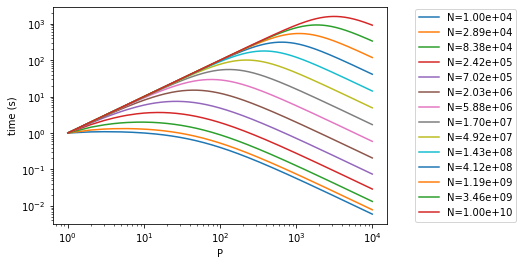

In [48]:
def speedup(p, n):
    return time(1, n) / time(p, n)

p = p_points[:10000]

n_points_new = np.logspace(4, 10, 14)
scales = speedup(*np.meshgrid(p, n_points_new)).T

n_legend = ["N={:.2e}".format(n) for n in n_points_new ] 

fig, ax = plt.subplots()
ax.loglog(p, scales)
ax.set_xlabel("P")
ax.set_ylabel("time (s)")
ax.legend(n_legend, loc='center right', bbox_to_anchor=(1.4, 0.5))

plt.show()